### Problem Statements
1. Reddit posts are extremely large, it is near to impossible to sort all the posts manually.
2. How to utilise machine learning ability(NLP) to organise the posts into a logical acceptable way. 

### In this section we will carry out:
[A. API Scrapping](#A.API-Scrapping) <br>
[B. Data Cleaning](#B.Data-Cleaning) <br>
[C. Modeling](#C.Modeling) <br>
[D. Model Evaluation](#D.Model-Evaluation) <br>
[E. Conclusion and Recommendation](#E.Conclusion-and-Recommendation)


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import regex as re
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

## A.API Scrapping 

In [2]:
#prepare the reddit title that we are intrested in
url_1 = 'https://www.reddit.com/r/marvel.json'  
url_2 = 'https://www.reddit.com/r/dccomics.json'  

In [3]:
#create a function to capture posts
def get_post(url, csv_name):

    posts = []
    after = None

    for a in range(35):
        if after == None:
            current_url = url
        else:
            current_url = url + '?after=' + after
        print(current_url)
        res = requests.get(current_url, headers={'User-agent': 'Data Inc'})
    
#if unable to access reddit, print the error and 'after' so we know where should we continue from
        if res.status_code != 200:
            print('Status error', res.status_code)
            print(after)
            break
    
        current_dict = res.json()
        current_posts = [p['data'] for p in current_dict['data']['children']]
        posts.extend(current_posts)
        after = current_dict['data']['after']
    
        if a > 0:
#read the previous posts, concat it with the current posts and save 
            prev_posts = pd.read_csv(csv_name)
            current_df = pd.DataFrame(current_posts) 
            current_df = pd.concat([prev_posts, current_df])
            pd.DataFrame(current_df).to_csv(csv_name, index = False)
        
        else:
            pd.DataFrame(posts).to_csv(csv_name, index = False)

# generate a random sleep duration to look more 'natural'
        sleep_duration = random.randint(2,10)
        time.sleep(sleep_duration)

In [4]:
#get posts for marvel
#get_post(url_1, '../datasets/marvel.csv')

In [3]:
marvel = pd.read_csv('../datasets/marvel.csv')

#carry out this step to remove any duplicate
marvel.drop_duplicates(subset='title', keep='first', inplace=True)
len(marvel)

876

In [4]:
#get posts for DCcomics
#get_post(url_2, '../datasets/dc.csv')

In [5]:
dc = pd.read_csv('../datasets/dc.csv')

In [ ]:
conv

## B.Data Cleaning 

In [6]:
#carry out this step to remove any duplicate
dc.drop_duplicates(subset='title', keep='first', inplace=True)

len(dc)

873

In [7]:
#combine both dataframe 
df = pd.concat([marvel,dc])

#check for na in 'title' and 'selftext'
df['title'].isnull().sum()

/Users/chowmun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


0

In [8]:
df['selftext'].isnull().sum()

1016

In [15]:
#join the text from 'title' and 'selftext'
#need to fill na with 'none' for 'selftext', else the operation cannot be done
df['selftext'].fillna('none', inplace=True)

df['content']=df['title'] +' '+ df['selftext']


In [12]:
#convert the target into binary result
df['subreddit'].replace({'Marvel': 1, 'DCcomics': 0}, inplace=True)

#checking 
df.subreddit.head()

0    1
1    1
2    1
3    1
4    1
Name: subreddit, dtype: int64

In [13]:
# Function to clean the data
def text_to_words(content):
    
    # 1. keep only alphabets.
    letters_only = re.sub("[^a-zA-Z]", " ", content)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. Add on own words to stop words and convert them to a set for a faster search
    my_stops = stopwords.words('english')
    my_stops.extend(['none','\n', 'www', 'reddit', 'com', 'comment', 'http'])
    my_stops = set(my_stops)
    
    # 4. Remove stop words.
    meaningful_words = [w for w in words if not w in my_stops]
    
    # 5. lemmatizer the words.
    lemmatizer = WordNetLemmatizer()
    tokens_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # 6. Join the words back into one string separated by space, and return the result.
    return(' '.join(tokens_lem))

In [14]:
#call the function to clean df['content']
clean_text=[]

for text in df['content']:
     # Convert text to words, then append to clean_text.
    clean_text.append(text_to_words(text))

In [15]:
#check for the outcome
clean_text[0:5]

['marvel comic sale may following total number marvel comic book sold comic shop month may total number comic sold customer kinda thing tracked much comic success really indicated whether get second printing meaning essentially sold everywhere number ranking essence box office result comic industry data based information collected comichron http comichron monthlycomicssales html rank series issue release date copy sold savage avenger amazing spider man immortal hulk amazing spider man war realm immortal hulk war realm venom war realm new agent atlas star war galaxy edge amazing spider man hu symbiote spider man fantastic four avenger thor guardian galaxy uncanny x men uncanny x men star war star war age rebellion boba fett thanos star war spider man life story captain america star war age rebellion han solo mile morale spider man star war vader dark vision star war age rebellion jabba hutt daredevil conan barbarian daredevil major x cosmic ghost rider destroys marvel history friendly n

In [16]:
#assign target and result to y and X then carry out train test split
y = df['subreddit']
X = clean_text

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Baseline accuracy 

In [18]:
y.value_counts(normalize=True)

1    0.500858
0    0.499142
Name: subreddit, dtype: float64

## C.Modeling 
a. Utilise pipeline to include 2 stages in modelling which are vectorizing and modeling.<br>
b. Compare the accuracy for LogisticRegression and MultinomialNB.<br>

#### CountVectorizer and LogisticRegression

In [19]:
#pipeline for LogisticRegression
pipe = Pipeline([('cvec', CountVectorizer()),
                 ('lr', LogisticRegression())
                ])

i. First we will evaluate the model using cross validation.<br>
ii. Then we will use predefined parameter to evaluate the model.<br>
iii. Tune the hyperparameters using GridSearchCV and get the score.

In [20]:
#i. Evaluate how your model will perform on unseen data
cross_val_score(pipe, X_train, y_train, cv=5)

/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

array([0.87072243, 0.90458015, 0.91603053, 0.92366412, 0.92748092])

In [21]:
cross_val_score(pipe, X_train, y_train, cv=5).mean() 

/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

0.9084956317301831

In [22]:
# ii. Fit into model
pipe.fit(X_train, y_train)

# Training score
print(pipe.score(X_train, y_train))

# Test score
print(pipe.score(X_test, y_test))

/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9954233409610984
0.9315068493150684


In [23]:
# iii. List the adjustable parameters
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cvec', 'lr', 'cvec__analyzer', 'cvec__binary', 'cvec__decode_error', 'cvec__dtype', 'cvec__encoding', 'cvec__input', 'cvec__lowercase', 'cvec__max_df', 'cvec__max_features', 'cvec__min_df', 'cvec__ngram_range', 'cvec__preprocessor', 'cvec__stop_words', 'cvec__strip_accents', 'cvec__token_pattern', 'cvec__tokenizer', 'cvec__vocabulary', 'lr__C', 'lr__class_weight', 'lr__dual', 'lr__fit_intercept', 'lr__intercept_scaling', 'lr__l1_ratio', 'lr__max_iter', 'lr__multi_class', 'lr__n_jobs', 'lr__penalty', 'lr__random_state', 'lr__solver', 'lr__tol', 'lr__verbose', 'lr__warm_start'])

In [24]:
pipe_params = {
    'cvec__max_features': [1500, 2000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.5, .6, .7, .8],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)

In [25]:
%time gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

CPU times: user 26.8 s, sys: 680 ms, total: 27.5 s
Wall time: 28.1 s
0.9069412662090007


/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'cvec__max_df': 0.5,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [26]:
gs.score(X_train, y_train)

0.9893211289092296

In [27]:
gs.score(X_test, y_test)

0.9223744292237442

#### CountVectorizer and MultinomialNB

In [28]:
#pipeline for Mulitnomial Naive Bayers
pipe2 = Pipeline([('cvec', CountVectorizer()),
                 ('nb', MultinomialNB())
                ])

Multinomial Naive Bayes classifier is suitable for classification with discrete features.<br>
i. Evaluate the model using cross validation.<br>
ii. Evaluate the model using default parameters.<br>
iii. Tune the hyperparameters using GridSearchCV and get the score.

In [29]:
# i. Evaluation using cross val score
cross_val_score(pipe2, X_train, y_train, cv=5)

array([0.88973384, 0.90076336, 0.90458015, 0.91221374, 0.91984733])

In [30]:
cross_val_score(pipe, X_train, y_train, cv=5).mean() 

/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

0.9084956317301831

In [31]:
# ii. Fit into model
pipe2.fit(X_train, y_train)

# Training score
print(pipe2.score(X_train, y_train))

# Test score
print(pipe2.score(X_test, y_test))

0.9679633867276888
0.908675799086758


In [32]:
#iii. List the adjustable hyperparameters
pipe2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cvec', 'nb', 'cvec__analyzer', 'cvec__binary', 'cvec__decode_error', 'cvec__dtype', 'cvec__encoding', 'cvec__input', 'cvec__lowercase', 'cvec__max_df', 'cvec__max_features', 'cvec__min_df', 'cvec__ngram_range', 'cvec__preprocessor', 'cvec__stop_words', 'cvec__strip_accents', 'cvec__token_pattern', 'cvec__tokenizer', 'cvec__vocabulary', 'nb__alpha', 'nb__class_prior', 'nb__fit_prior'])

In [33]:
pipe_params2 = {
    'cvec__max_features': [1500, 2000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.5, .6, .7, .8],
    'cvec__ngram_range': [(1,1), (1,2)],
}
gs2 = GridSearchCV(pipe2, param_grid=pipe_params2, cv=5)

In [34]:
%time gs2.fit(X_train, y_train)
print(gs2.best_score_)
gs2.best_params_

CPU times: user 25.2 s, sys: 675 ms, total: 25.9 s
Wall time: 26.6 s
0.9038901601830663


{'cvec__max_df': 0.5,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [35]:
gs2.score(X_train, y_train)

0.938977879481312

In [36]:
gs2.score(X_test, y_test)

0.8972602739726028

## D.Model Evaluation 
Createa a function to plot the confusion table for the data.

In [37]:
def c_matrix(model, X_test):
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)            # calculate predictions
    cm = confusion_matrix(y_test, y_pred)     # defining the confusion matrix
    tn, fp, fn, tp = cm.ravel()               # assigning the elements of the confusion matrix to variables
    
    return pd.DataFrame(cm, 
                        columns = ['Pred Marvel','Pred DC'], 
                        index = ['Act Marvel', 'Act DC'])

#### Confusion table:
In our context:<br>
a.True Positive/Negative means the model predicts correctly the post is from subreddit Marvel/DC.<br>
b.False Positive/Negative means the model wrongly predicts the post is from subreddit Marvel/DC.

In [38]:
c_matrix(pipe, X_test) #LogisticRegression

/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Pred Marvel,Pred DC
Act Marvel,192,21
Act DC,9,216


In [39]:
c_matrix(pipe2, X_test) #MultinomialNB

,Pred Marvel,Pred DC
Act Marvel,205,8
Act DC,32,193


For this case, False Postive(FP) and False Negative(FN)  mean they are wrongly classified in the subreddit.<br>
Both have the equal impact, so we need to have a model with high accuracy. <br>
It seems like LogisticRegression done a better job with a lower number of FP and FN.

#### Classification Table

In [40]:
#write a function for Classification Report
def report(model, X_test):
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test) 
    print('Classification Report')
    print(classification_report(y_test, y_pred))

In [41]:
report(pipe, X_test)

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       213
           1       0.91      0.96      0.94       225

    accuracy                           0.93       438
   macro avg       0.93      0.93      0.93       438
weighted avg       0.93      0.93      0.93       438



/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [42]:
report(pipe2, X_test)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       213
           1       0.96      0.86      0.91       225

    accuracy                           0.91       438
   macro avg       0.91      0.91      0.91       438
weighted avg       0.91      0.91      0.91       438



From both of the reports, we notice that LogisticRegression score higher in both accuracy and precision.<br>
In average LogisticRegression is able to predict correctly 93% of the posts, which is 2% higher than nb and 43% higher than the baseline. <br>
Then, the precision score for LogisticRegression is 93%. 

#### Receiver operating characteristic(ROC) curves

/Users/chowmun/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


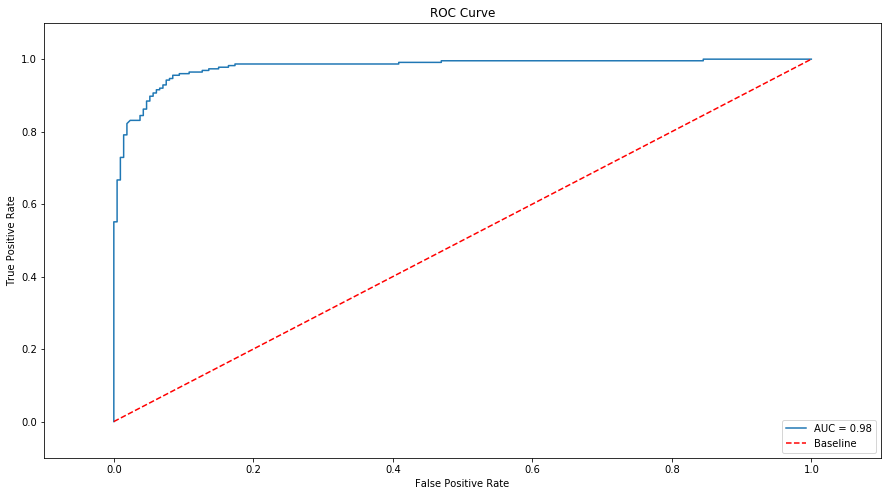

In [43]:
plt.figure(figsize=(15,8))

pipe.fit(X_train, y_train)
y_preds = pipe.predict_proba(X_test)
#y_preds2 = pipe2.predict_proba(X_test)
# take the second column because the classifier outputs scores for the 0 class as well
preds = y_preds[:,1]
#preds2 = y_preds2[:,1]

# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
#fpr2, tpr2, _ = metrics.roc_curve(y_test, preds2)
auc_score = metrics.auc(fpr, tpr)
#auc_score2 = metrics.auc(fpr2, tpr2)

plt.title('ROC Curve')
#plt.plot(fpr, tpr, label='LogisticRegression')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate threshold
plt.plot([0,1],[0,1],'r--', label='Baseline')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

The performance of a classification model at all classification thresholds can be checked by using ROC. <br>
The ROC curve is plotted with TPR against the FPR.<br>
It shows the tradeoff between sensitivity and specificity.<br>
The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.<br>
As shown in the graph, our model done a pretty good job.

In [44]:
#to access the model in pipeline, when need to access it individually
step1 = pipe.named_steps['cvec']
step2 = pipe.named_steps['lr']

In [45]:
#get the feature name 
columns=(step1.get_feature_names())

#form the df by combining features name and the coef
coef = pd.DataFrame(step2.coef_, columns=columns)
marvel_coef = coef.T.sort_values(by = 0, ascending=False) #by 0 means the by index a

marvel_coef.head(10)

,0
marvel,2.241585
spider,1.640239
avenger,1.559392
mcu,1.521232
men,1.478167
phoenix,1.322232
spiderman,1.169903
thanos,1.053813
war,1.052785
endgame,0.971164


In [46]:
dc_coef = coef.T.sort_values(by = 0, ascending=True)

dc_coef.head(10)

,0
dc,-2.693030
batman,-2.612937
excerpt,-2.288712
artwork,-2.147096
swamp,-1.715658
superman,-1.486030
joker,-1.456851
plastic,-1.329643
justice,-1.289678
leviathan,-1.200361


For a one unit increase in the word 'marvel', the probability of a reddit post being an 'Marvel' subreddit increases by 2.24 times.<br>
while for a one unit increase in the world 'dc', the probablity of a reddit post being an 'Marvel' subreddit decreases by 2.69 times.<br>
The features shown are the important words used by NLP in identify the subreddit of a post.

## E.Conclusion and Recommendation

1. Some of the posts contains only a few words and it is hard for the model to predict the outcome accurately. <br>
2. The model performs better under LogisticRegression with the average accuracy of 0.93 and average precision of 0.93. It is performs far more better from the baseline.<br>
3. Given our preliminary findings we would recommend that the Reddit data science team move forward with the LogisitcRegression. 
4. In future, we could use pic posted in a post as a feature to classify a subreddit.